# CHEM 101.6 Project4

This is a Jupyter notebook for running and analyzing a Molecular Dynamics (MD) simulation of the fast-folding variant of the Villin headpiece.
Scaffolded by Professor Paul Robustelli and completed by Jacob Wesley Dell for 10 February 2022 (revised for the end of the term).

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import math
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import seaborn as sns
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import sklearn
from sklearn.decomposition import PCA
import itertools
import mdtraj as md

This is a 125 microsecond trajectory of fast folding variant of the Villin Headpiece generated from DEShaw Research:

https://www.science.org/doi/full/10.1126/science.1208351

It can be compared to an X-ray structure:
https://www.rcsb.org/structure/2F4K
(Note that the x-ray structure has multiple positions for some sidechain atoms)

You can download the required files here:
https://www.dropbox.com/s/60jxmiuvlyehbhz/Villin_Lab.zip?dl=0

In [2]:
pdb='Villin_Lab/2F4K.protein.pdb'
trajectory='Villin_Lab/2F4K.protein.s10.dcd'
xray_CA_pdb='Villin_Lab/2f4K.xray.CA.pdb'
outdir='Villin_Lab/output'
if not os.path.exists(outdir):
    os.makedirs(outdir)
    
print("outdir:",outdir)
print("pdb:",pdb)
print("trjaectory:",trajectory)

outdir: Villin_Lab/output
pdb: Villin_Lab/2F4K.protein.pdb
trjaectory: Villin_Lab/2F4K.protein.s10.dcd


In [3]:
stride_sel=10
trj = md.load(trajectory, top=pdb, stride=stride_sel)
trj.center_coordinates()
top = trj.topology
first_frame=0
last_frame = trj.n_frames
n_frames = trj.n_frames
trj_length=125
time = np.linspace(0,125,n_frames)

In [4]:
nres=[]
for res in trj.topology.residues: nres.append(res.resSeq)
sequence=(' %s' % [residue for residue in trj.topology.residues])
resname=(' %s' % [residue.name for residue in trj.topology.residues])
resindex=(' %s' % [residue.index for residue in trj.topology.residues])
res_num=(' %s' % [residue.resSeq  for residue in trj.topology.residues])

print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue number: %s\n" % res_num)
print("residue index: %s" % resindex)

** SYSTEM INFO **

Number of atoms: 577

Number of residues: 35

Number of frames: 6280

Starting frame: 0

Last frame: 6280

sequence:  [LEU42, SER43, ASP44, GLU45, ASP46, PHE47, LYS48, ALA49, VAL50, PHE51, GLY52, MET53, THR54, ARG55, SER56, ALA57, PHE58, ALA59, ASN60, LEU61, PRO62, LEU63, TRP64, NLE65, GLN66, GLN67, HIS68, LEU69, NLE70, LYS71, GLU72, LYS73, GLY74, LEU75, PHE76, LEU42, SER43, ASP44, GLU45, ASP46, PHE47, LYS48, ALA49, VAL50, PHE51, GLY52, MET53, THR54, ARG55, SER56, ALA57, PHE58, ALA59, ASN60, LEU61, PRO62, LEU63, TRP64, NLE65, GLN66, GLN67, HIS68, LEU69, NLE70, LYS71, GLU72, LYS73, GLY74, LEU75, PHE76]

residue names:  ['LEU', 'SER', 'ASP', 'GLU', 'ASP', 'PHE', 'LYS', 'ALA', 'VAL', 'PHE', 'GLY', 'MET', 'THR', 'ARG', 'SER', 'ALA', 'PHE', 'ALA', 'ASN', 'LEU', 'PRO', 'LEU', 'TRP', 'NLE', 'GLN', 'GLN', 'HIS', 'LEU', 'NLE', 'LYS', 'GLU', 'LYS', 'GLY', 'LEU', 'PHE', 'LEU', 'SER', 'ASP', 'GLU', 'ASP', 'PHE', 'LYS', 'ALA', 'VAL', 'PHE', 'GLY', 'MET', 'THR', 'ARG', 'SER', 'ALA

In [5]:
residue_num=[]
for res in top.residues: 
    residue_num.append(res.resSeq)
residue_id = np.asarray(residue_num)

In [6]:
xray_CA = md.load_pdb(xray_CA_pdb)
top_xray = xray_CA.topology
top_xray
residue_xray=[]
for res in top_xray.residues: 
    residue_xray.append(res.resSeq)
resid_xray = np.asarray(residue_xray)
print(resid_xray)

[42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65
 66 67 68 69 70 71 72 73 74 75 76]


In [7]:
#Use DSSP to calculate the secondary structure definition
#https://mdtraj.org/1.9.4/api/generated/mdtraj.compute_dssp.html
trjBB = md.load(trajectory, top=pdb,stride=stride_sel)
BB=top.select("backbone")
trjBB.restrict_atoms(BB)
trjBB.center_coordinates()

dssp=md.compute_dssp(trjBB,simplified=True)

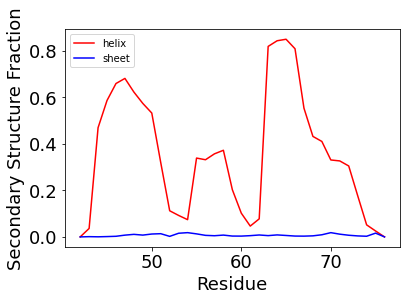

In [8]:
def dssp_convert(dssp):
 dsspH=np.copy(dssp)
 dsspE=np.copy(dssp)
 dsspH[dsspH=='H']=1                                                                                      
 dsspH[dsspH=='E']=0                                                                                      
 dsspH[dsspH=='C']=0                                                                                      
 dsspH[dsspH=='NA']=0 
 dsspH=dsspH.astype(int)
 TotalH=np.sum(dsspH,axis=1) 
 Hprop=np.sum(dsspH,axis=0).astype(float)/len(dsspE) 

 dsspE[dsspE=='H']=0
 dsspE[dsspE=='E']=1
 dsspE[dsspE=='C']=0
 dsspE[dsspE=='NA']=0
 dsspE=dsspE.astype(int)
 TotalE=np.sum(dsspE,axis=1) 
 Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE) 
 return Hprop, Eprop

Hprop,Eprop=dssp_convert(dssp)
plt.plot(resid_xray,Hprop,c='r',label='helix')
plt.plot(resid_xray,Eprop,c='b',label='sheet')

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Structure Fraction', size=18)
plt.tick_params(labelsize=18)

In [9]:
indices_phi, phis = md.compute_phi(trj)
indices_psi, psis = md.compute_psi(trj)
indices_chi1, chi1s = md.compute_chi1(trj)
indices_chi2, chi2s = md.compute_chi2(trj)

In [10]:
phi_dict={}
dihedral_dict = { 'phi': { },
          'psi': { },
          'chi1': { },
          'chi2': { }}

for i in range(0,len(indices_phi)):
  indices=indices_phi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['phi'][resnum]=phis[:,i]

for i in range(0,len(indices_psi)):
  indices=indices_psi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['psi'][resnum]=psis[:,i]

for i in range(0,len(indices_chi1)):
  indices=indices_chi1[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi1'][resnum]=chi1s[:,i]

for i in range(0,len(indices_chi2)):
  indices=indices_chi2[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi2'][resnum]=chi2s[:,i]

In [11]:
#Heres a function to plot a phi/psi ramachandran plot:

def plot_phipsi(res):
 plt.hist2d(dihedral_dict['phi'][res],dihedral_dict['psi'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.tick_params(labelsize=18)
 plt.show()
 return

def plot_chi(res):
    if res in dihedral_dict['chi1']:
     plt.hist(dihedral_dict['chi1'][res],bins=36,range=[-3.14,3.14])        
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('counts', size=18)
     plt.tick_params(labelsize=18)
     plt.show()
     plt.clf()   
    if res in dihedral_dict['chi2']:
     plt.hist2d(dihedral_dict['chi1'][res],dihedral_dict['chi2'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('$\chi_2$', size=18)
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.tick_params(labelsize=18)
     plt.show()
    return

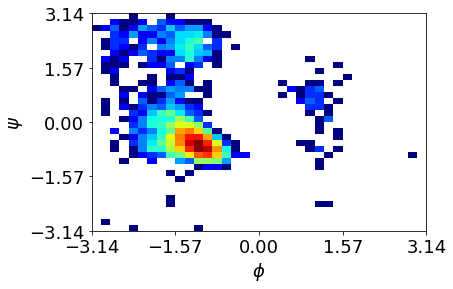

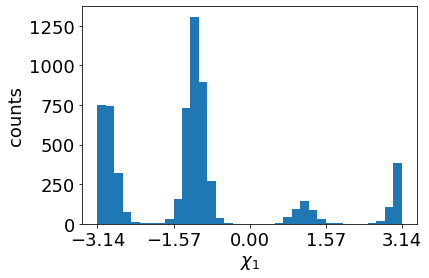

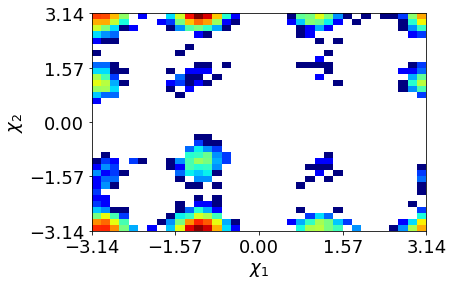

In [12]:
plot_phipsi(66)
plot_chi(66)

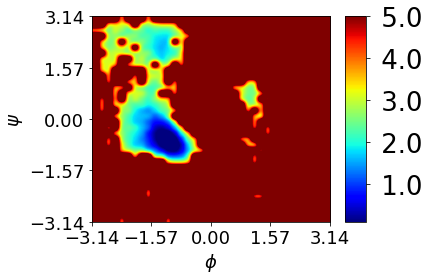

In [13]:
def plot_phipsi_FES(res):
 free_energy,xedges,yedges=np.histogram2d(dihedral_dict['psi'][res],dihedral_dict['phi'][res],36,[[-3.14,3.14],[-3.14,3.14]],normed=True,weights=None)
 free_energy=np.log(np.flipud(free_energy)+.000001)
 T=300                                                                                                  
 kbT=T*0.008314/4.184 # kT in kcal/mol
 dG=-(kbT)*free_energy #Convert to kcal/mol
 im=plt.imshow(dG, interpolation='gaussian',extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],cmap='jet',aspect='auto')
 cbar_ticks=[0,1,2,3,4,5]
 cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'), aspect=10) # grab the Colorbar instance
 imaxes = plt.gca()                                                                                                 
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.tick_params(labelsize=18)
 plt.axes(cb.ax)
 plt.clim(vmin=0.1,vmax=5.0)
 plt.yticks(size='26')
 plt.tight_layout()
 plt.show()
 return

plot_phipsi_FES(66)

In [14]:
trjCA = md.load(trajectory, top=pdb, stride=stride_sel)
CA=top.select("name CA")
trjCA.restrict_atoms(CA)
trjCA = trjCA.center_coordinates()

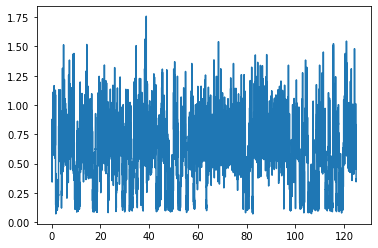

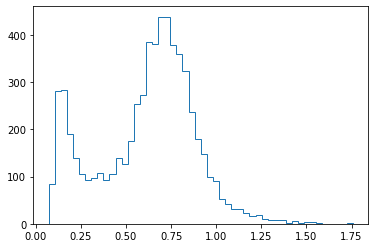

In [15]:
CA_trj_sel=trj.topology.select("name CA")
CA_xray_sel=xray_CA.topology.select("name CA")
rmsd = md.rmsd(trjCA,xray_CA)
plt.plot(time,rmsd)
plt.show()
plt.clf()

plt.hist(rmsd,histtype='step',bins=50)
plt.show()

In [16]:
native_frames=np.where(rmsd<0.25)[0]
print(len(native_frames))

1016


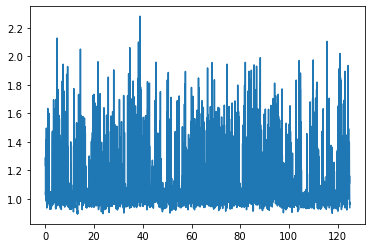

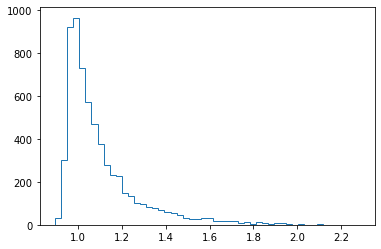

In [17]:
# calculate the radius of gyration
rg=md.compute_rg(trj, masses=None)
plt.plot(time,rg)
plt.show()
plt.clf()

plt.hist(rg,histtype='step',bins=50)
plt.show()

In [18]:
import sklearn
from sklearn.decomposition import PCA

pca1 = PCA(n_components=2)
trj.superpose(trj, 0)
reduced_cartesian = pca1.fit_transform(trj.xyz.reshape(trj.n_frames, trj.n_atoms * 3))
print(reduced_cartesian.shape)

(6280, 2)


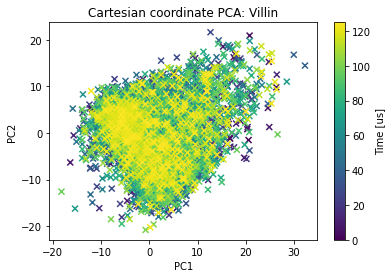

In [19]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=time)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('Time [us]')

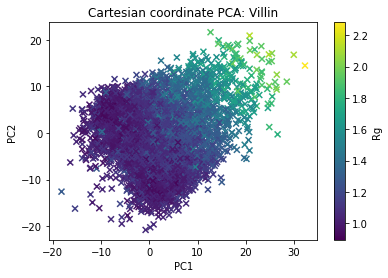

In [20]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=rg)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('Rg')

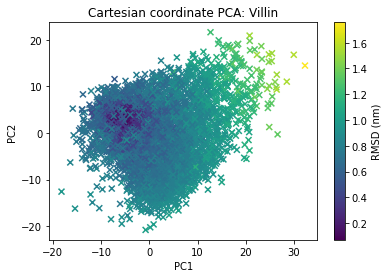

In [21]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=rmsd)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('RMSD (nm)')

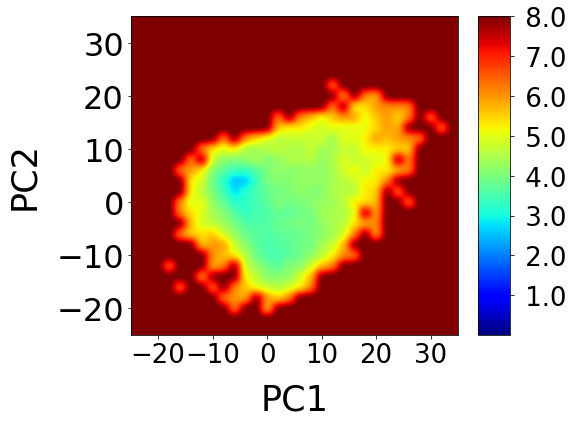

In [22]:
def free_energy(a, b, T, y0, ymax, x0, xmax):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], normed=True, weights=None)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges

PC1=reduced_cartesian[:, 0]
PC2=reduced_cartesian[:,1]

dG,xedges,yedges=free_energy(PC2, PC1, 300, -25, 35, -25, 35)

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5,6,7,8]
plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("PC2", size=35, labelpad=15)
plt.xlabel("PC1", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='26')
plt.tight_layout()

### classroom activity: plot the free energy as a function of RMSD and radius of gyration

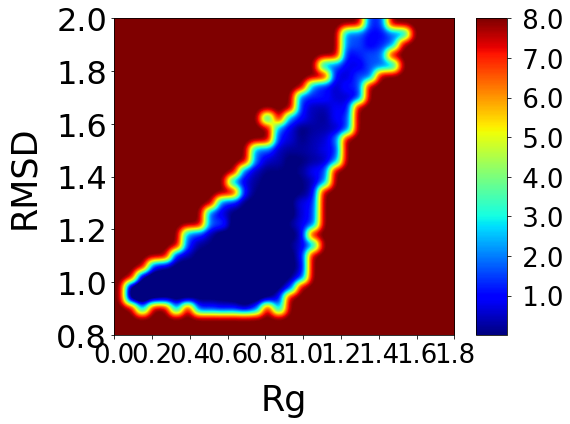

/home/jwdell/anaconda3/envs/new_chem101/lib/python3.7/site-packages/ipykernel_launcher.py:29: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.


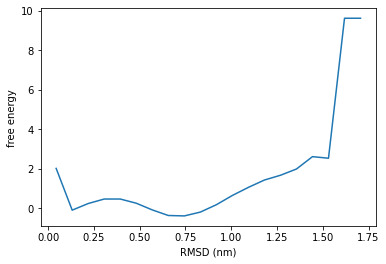

In [23]:
# from solutions posted on slack
dG,xedges,yedges=free_energy(rg, rmsd, 300, 0.8, 2.0, 0, 1.8)

fig = plt.figure(figsize=(8, 6))
#im = plt.imshow(dG, extent=[
#                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5,6,7,8]
#plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("RMSD", size=35, labelpad=15)
plt.xlabel("Rg", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='26')
plt.tight_layout()
plt.show()

# from solutions posted in slack
def free_energy1D(a,T,x0,xmax,bins):
    free_energy, xedges= np.histogram(
        a, bins, [x0, xmax], normed=True, weights=None)
    xcenters= xedges[:-1] + np.diff(xedges)/2
    free_energy = np.log(free_energy+.0000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xcenters
dG,xedges=free_energy1D(rmsd, 300, 0, 1.75, 20)
plt.clf()
plt.xlabel("RMSD (nm)")
plt.ylabel("free energy")
plt.plot(xedges,dG)
plt.show()

In [24]:
# make a contact map
contact_maps = []
contact_distances = []

for i in range(0, 34):
    contact_map = []
    contact_distance = []
    for j in range(0, 34):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj, [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 0.5, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)

In [25]:
#Lets Make Nice Contact Map Labels
sequence=[]
for residue in trj.topology.residues:
    sequence.append(residue)

#Lets Zero Out some of the Labels 
n=2
for i in range (0,len(sequence)): 
  if (i % n !=0):
   sequence[i]=''

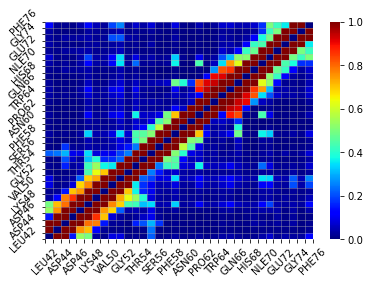

In [26]:
ax = sns.heatmap(final_map, vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,35))
ax.set_yticks(range(0,35))
ax.set_xticklabels(sequence[:35],rotation=45)
ax.set_yticklabels(sequence[:35],rotation=45)
plt.show()

In [27]:
def circular_mean(angle):
    return np.arctan2(np.sum(np.sin(angle)),np.sum(np.cos(angle)))

def circular_corr(angle1,angle2):
    cmean1=circular_mean(angle1)
    cmean2=circular_mean(angle2)
    numerator=(np.sum(np.sin(angle1-cmean1)*np.sin(angle2-cmean2)))
    denom=((np.sum(np.sin(angle1-cmean1)**2)*np.sum(np.sin(angle2-cmean2)**2))**.5)
    ccor=numerator/denom
    return ccor

In [28]:
# Make correlation contact map
correlation_maps = []
for i in range(43, 76):
    cor_map = []
    for j in range(43, 76):
        phi=dihedral_dict['phi'][i]
        psi=dihedral_dict['psi'][j]
        ccor=circular_corr(psi,phi)
        cor_map.append(ccor)
    correlation_maps.append(cor_map)
final_cor_map = np.asarray(correlation_maps).astype(float)
print(np.shape(final_map))

(34, 34)


In [29]:
sequence=[]
for residue in trj.topology.residues:
    sequence.append(residue)
len(sequence)
seq_trunc=sequence[1:34]
# zero out some of the Labels 
n=2
for i in range (0,33): 
  if (i % n !=0):
   seq_trunc[i]=''

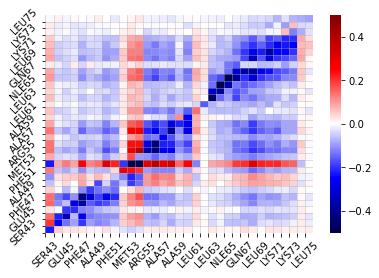

In [30]:
mask = np.zeros_like(final_map)
zeros = np.where((final_map<0.10) & (final_map>-0.10))
mask[zeros] = True
ax = sns.heatmap(final_cor_map, vmin=-0.5, vmax=0.5,cmap='seismic')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,33))
ax.set_yticks(range(0,33))
ax.set_xticklabels(seq_trunc,rotation=45)
ax.set_yticklabels(seq_trunc,rotation=45)
plt.show()

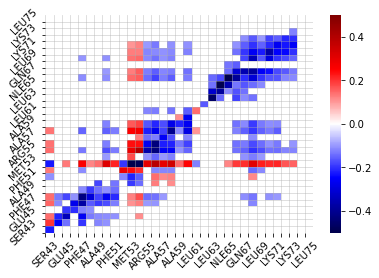

In [31]:
mask = np.zeros_like(final_cor_map)
zeros = np.where((final_cor_map<0.10) & (final_cor_map>-0.10))
mask[zeros] = True
ax = sns.heatmap(final_cor_map,mask=mask, vmin=-0.5, vmax=0.5, cmap='seismic')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,33))
ax.set_yticks(range(0,33))
ax.set_xticklabels(seq_trunc,rotation=45)
ax.set_yticklabels(seq_trunc,rotation=45)
plt.show()

try to reproduce the free energy plot from
https://www.science.org/doi/full/10.1126/science.1208351

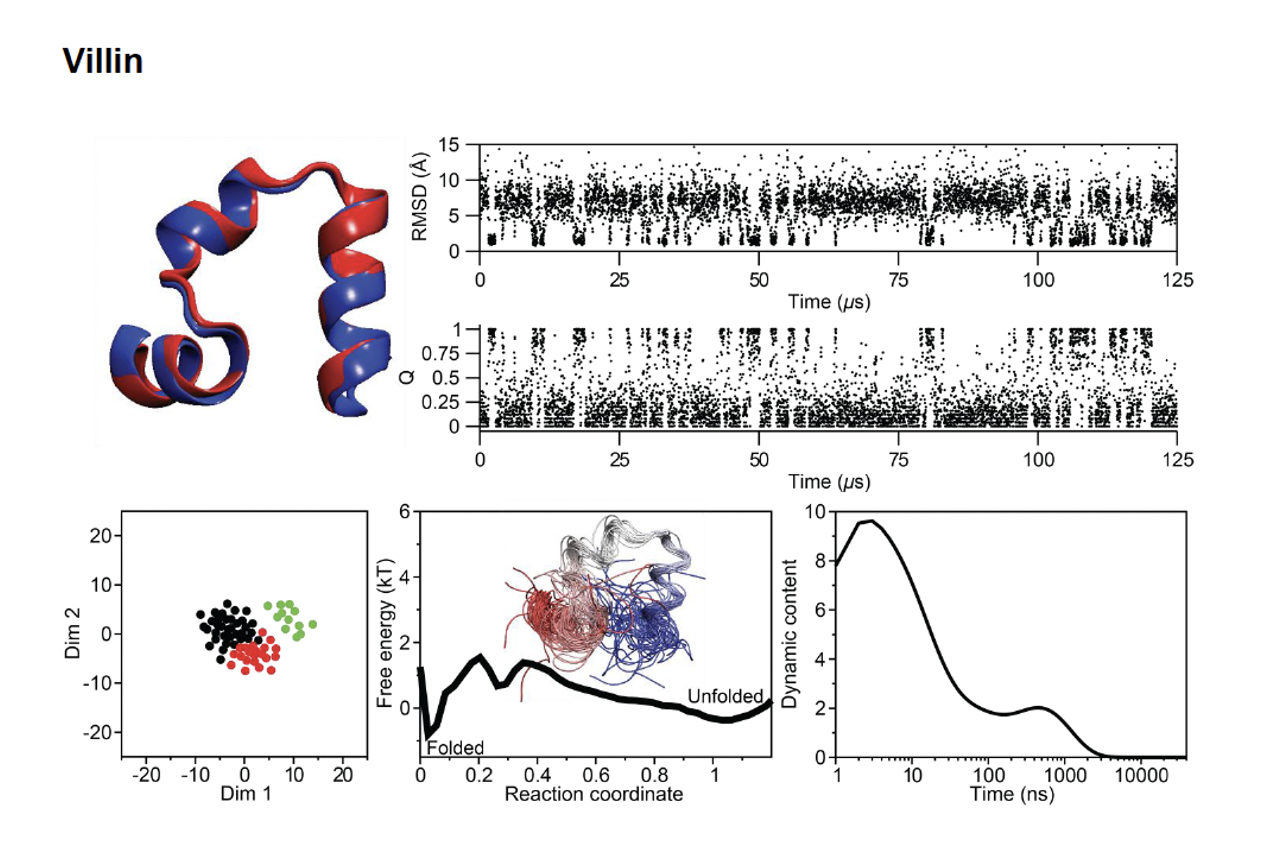

First we need to determine the native contacts and calculate Q

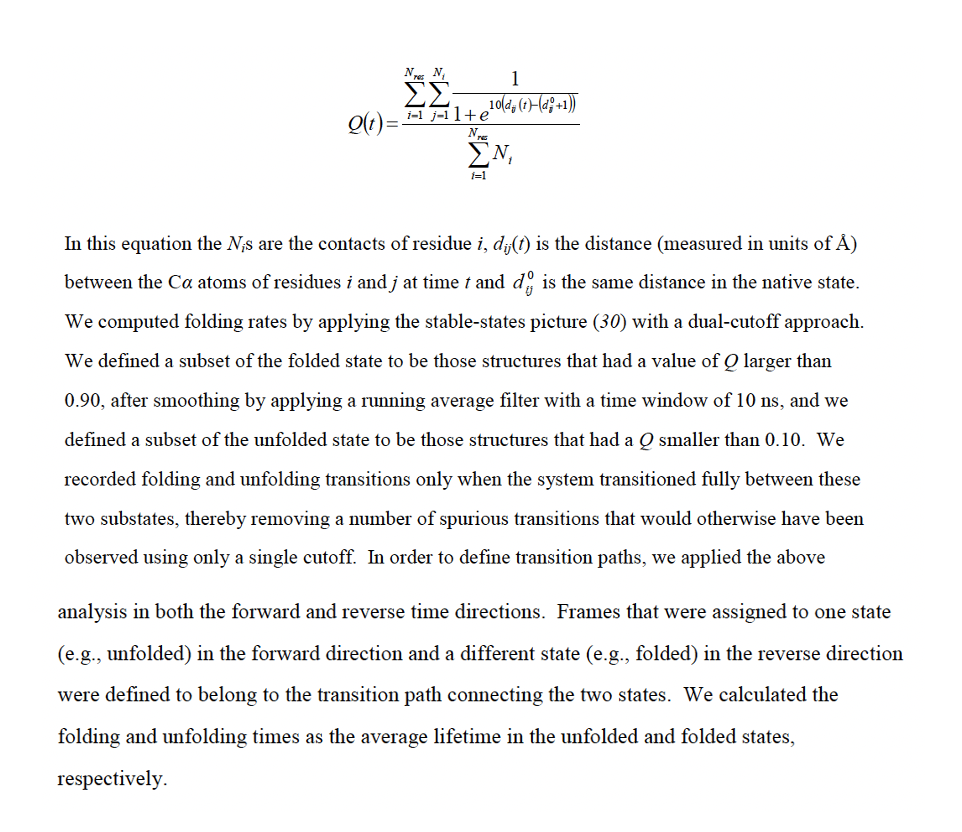

In [32]:
# from class activity
# make a 1D array that contains all native distances pairs:
#QUESTION: How can you make a 1D Array that only contains distances
# between residue pairs separated by more than 7 residues?
native_distance_matrix1D=[]
for i in range(35):
    for j in range(35):
        if np.abs(i-j)>7:
            dist = md.compute_distances(xray_CA,[[i,j]])[:,0]
            native_distance_matrix1D.append(dist[0])

# convert to angstroms
native_distance_matrix1D = np.asarray(native_distance_matrix1D)*10

In [33]:
# do the same thing for our trajectory, making an array that is contacts vs. n_frames in the trajectory
traj_CA_distance_matrix1D=[]
for i in range(35):
    for j in range(35):
        if np.abs(i-j)>7:
            dist = md.compute_distances(trjCA,[[i,j]])[:,0]
            traj_CA_distance_matrix1D.append(dist)

# convert to angstroms
traj_CA_distance_matrix1D = np.asarray(traj_CA_distance_matrix1D)*10

In [34]:
# make sure that for each distance you can compare that native distance to the trajectory distance 
# (distances for every Ca-Ca pair in the native frames)
native_dist = traj_CA_distance_matrix1D[:,native_frames]
native_average = np.average(native_dist,axis=1)

# select native averages < 10.0A
native_contact_indices = np.where(native_average<10.0)[0]
native_contacts_trj_dist = traj_CA_distance_matrix1D[native_contact_indices]
native_contacts_xray_dist = native_distance_matrix1D[native_contact_indices]

In [35]:
# expand native distance matrix so that it's the same number of frames as the trajectory
xray_distance_expand = np.zeros(np.shape(native_contacts_trj_dist))
for i in range(0,len(native_contacts_trj_dist)):
    xray_distance_expand[i,:] = native_contacts_xray_dist[i]

In [36]:
# write a function to calculate Q
# not sure why this is looking so funky.
#  haven't been able to get a better
#  distribution (more values toward 1)
def calc_Q(timedist,natdist):
    arg = 1 / (1 + np.exp(10*(timedist-natdist)))
    numsum = np.sum(arg,axis=0)
    return numsum / np.shape(timedist)[0]
Q = calc_Q(native_contacts_trj_dist,xray_distance_expand)

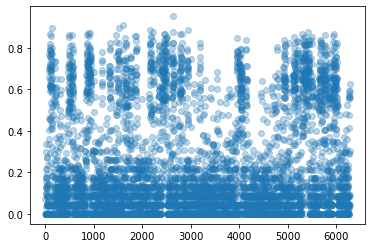

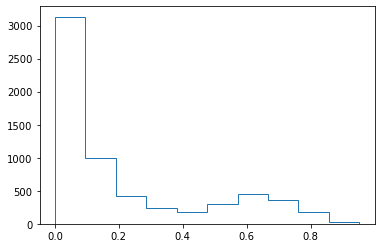

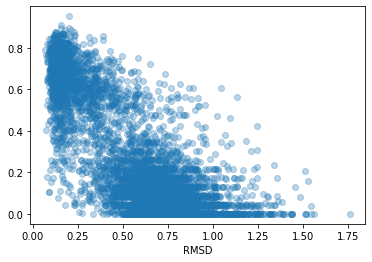

In [37]:
# plot Q and a histogram
plt.plot(Q,marker='o',alpha=.3,lw=0)
plt.show()
plt.clf()
plt.hist(Q,histtype='step')
plt.show()
plt.clf()
plt.scatter(rmsd,Q,marker='o',alpha=.3)
plt.xlabel('RMSD')
plt.show()

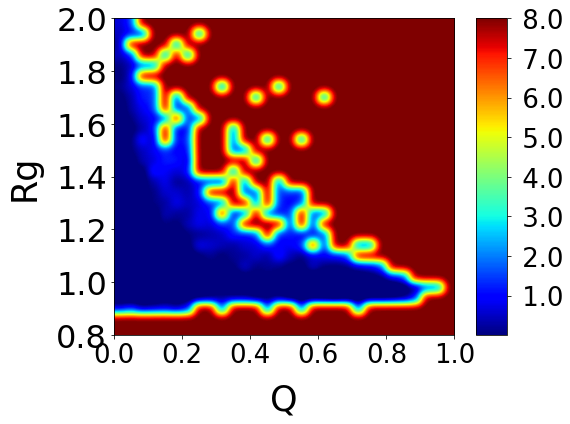

/home/jwdell/anaconda3/envs/new_chem101/lib/python3.7/site-packages/ipykernel_launcher.py:29: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.


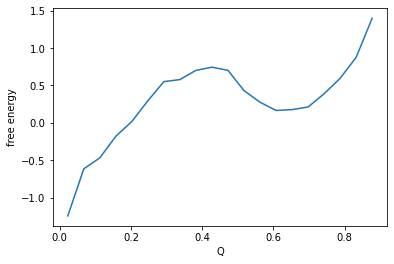

In [38]:
dG,xedges,yedges=free_energy(rg, Q, 300, 0.8, 2.0, 0, 1)

fig = plt.figure(figsize=(8, 6))
#im = plt.imshow(dG, extent=[
#                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5,6,7,8]
#plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("Rg", size=35, labelpad=15)
plt.xlabel("Q", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='26')
plt.tight_layout()
plt.show()

dG,xedges=free_energy1D(Q, 300, 0, .9, 20)
plt.clf()
plt.xlabel("Q")
plt.ylabel("free energy")
plt.plot(xedges,dG)
plt.show()

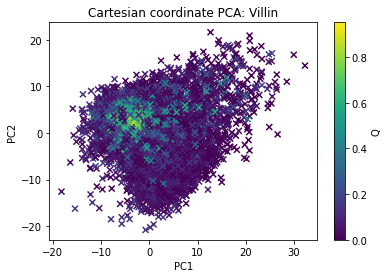

In [39]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=Q)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('Q')

In [40]:
# filter the distances based on only the "Native Portion" of the trajectory and recompute Q
filtered_Q = calc_Q(native_contacts_trj_dist[:,native_frames],xray_distance_expand[:,native_frames])

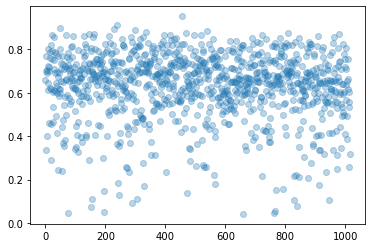

In [41]:
# plot Q using only our native frames
plt.plot(filtered_Q,marker='o',alpha=.3,lw=0)
plt.show()

In [42]:
# calculate the transition paths using the dual cutoff approach
# consider using a windowing function to smooth the values of Q
# Use the dual cut-off approach with Q to identify transition paths.
#  This means from the distribution of Q you decide on a threshold
#  for folded and unfolded states. Assign a transition between
#  two states as every event where you start beneath one threshold
#  and you cross over the second threshold.
# low threshold (unfolded) Q<.0000001; high threshold (folded) Q>.6536 (trial and error)

# Here is a trick to identify transition paths:
#  1) Assign frames to Folded or Unfolded states using the dual
#     cut-off approach going from time 0 to 125us
folded = np.where(Q>.6536)[0]
unfolded = np.where(Q<1e-7)[0]
#  2) Reverse the array of Q values (so it goes reverse from 125us to 0 us)
reverse_Q = np.flip(Q)
#  3) Assign frames to folded or unfolded states using the reversed array
reverse_folded = np.where(reverse_Q>.6536)[0]
reverse_unfolded = np.where(reverse_Q<1e-7)[0]
#  4) Reverse the direction of the assignments from step (3),
#     so it now has assignments from states going from 0 to 125 us
crossref_folded = np.flip(reverse_folded)
crossref_unfolded = np.flip(reverse_unfolded)
#  5) Everywhere the two areas don't match is a transition path
tp = np.intersect1d(folded,crossref_unfolded)
tp = np.sort(np.append(tp,np.intersect1d(unfolded,crossref_folded)))

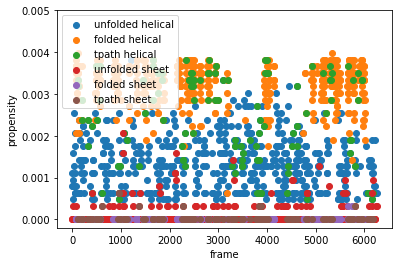

In [43]:
# not quite sure why this maxes out at 4e-3
# the most interesting observation to my eyes
#  is that unfolded residues have the greatest
#  sheet propensity (red dots)
def dssp_convert_revised(dssp):
    dsspH=np.copy(dssp)
    dsspE=np.copy(dssp)
    dsspH[dsspH=='H']=1                                                                                      
    dsspH[dsspH=='E']=0                                                                                      
    dsspH[dsspH=='C']=0                                                                                      
    dsspH[dsspH=='NA']=0 
    dsspH=dsspH.astype(int) 
    Hprop=np.sum(dsspH,axis=1).astype(float)/len(dsspH) 
    dsspE[dsspE=='H']=0
    dsspE[dsspE=='E']=1
    dsspE[dsspE=='C']=0
    dsspE[dsspE=='NA']=0
    dsspE=dsspE.astype(int) 
    Eprop=np.sum(dsspE,axis=1).astype(float)/len(dsspE) 
    return Hprop, Eprop

Hpropall,Epropall = dssp_convert_revised(dssp)
Hpropallunfold = Hpropall[unfolded]
Hpropallfold = Hpropall[folded]
Hpropalltp = Hpropall[tp]
Epropallunfold = Epropall[unfolded]
Epropallfold = Epropall[folded]
Epropalltp = Epropall[tp]
plt.scatter(unfolded,Hpropallunfold,label='unfolded helical')
plt.scatter(folded,Hpropallfold,label='folded helical')
plt.scatter(tp,Hpropalltp,label='tpath helical')
plt.scatter(unfolded,Epropallunfold,label='unfolded sheet')
plt.scatter(folded,Epropallfold,label='folded sheet')
plt.scatter(tp,Epropalltp,label='tpath sheet')
plt.legend()
plt.xlabel('frame')
plt.ylabel('propensity')
plt.axis(ymax=.005)
plt.show()